In [1]:
%matplotlib notebook
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import vtk
from vtk.util.numpy_support import vtk_to_numpy

import espressomd
from espressomd import assert_features, lb

In [2]:
assert_features(["ENGINE","LB_GPU","MASS","ROTATION","ROTATIONAL_INERTIA"])

In [3]:
mode        = "pusher"
pos         = 0.0
length      = 25.0
prod_steps  = 1000
prod_length = 50
dt          = 0.01

In [4]:
system = espressomd.System(box_l=[length, length, length])
system.cell_system.skin = 0.3
system.time_step = dt
system.min_global_cut = 1.0

In [5]:
# Set the position of the particle

x0 = 0.5*length
y0 = 0.5*length
z0 = 0.5*length + pos

# Sphere size, mass, and moment of inertia, dipole force

sph_size = 0.5
sph_mass = 4.8
Ixyz     = 4.8
force    = 0.1 

# Setup the particle particle

system.part.add(pos=[x0,y0,z0],type=0,mass=sph_mass, rinertia=[Ixyz,Ixyz,Ixyz],
                swimming={'f_swim':force, 'mode':mode, 'dipole_length':sph_size + 0.5})

In [6]:
# Setup the fluid (quiescent)

agrid = 1
vskin = 0.1
frict = 20.0
visco = 1.0
densi = 1.0
temp  = 0.0

lbf = lb.LBFluidGPU(agrid=agrid, dens=densi, visc=visco, tau=dt, fric=frict, couple='3pt')
system.actors.add(lbf)
system.thermostat.set_lb(kT=temp)

In [7]:
for k in range(prod_steps):
    # Output 50 simulations
    if k % (prod_steps/50) == 0:
        num = k/(prod_steps/50)
        lbf.print_vtk_velocity("lb_velocity_{}.vtk".format(num))
        system.part.writevtk("position_{}.vtk".format(num),types=[0])

    system.integrator.run(prod_length)

<IPython.core.display.Javascript object>


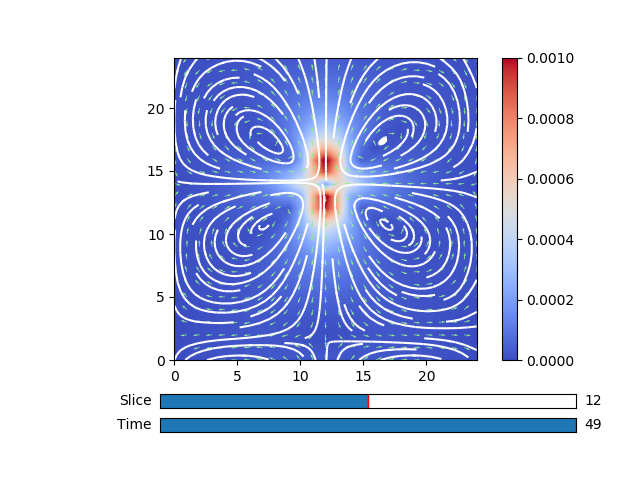

In [8]:
def read(time):
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName("lb_velocity_{}.vtk".format(time))
    reader.Update()
    data = reader.GetOutput().GetPointData()
    return vtk_to_numpy(data.GetArray(0)).reshape((25,25,25,3))

def plot(flow,cut):
    global img
    X, Y = np.meshgrid(range(25),range(25))
    U, V = flow[:,:,cut,1], flow[:,:,cut,2]
    norm = np.sqrt(U**2 + V**2)
    img = ax.imshow(np.linalg.norm(flow[:,:,cut,:],axis=2),
              origin='lower',cmap='coolwarm',
              interpolation='bilinear',extent=[0,24,0,24],
              vmin=0,vmax=0.001)
    ax.streamplot(X, Y, U, V, density=1, color="white", arrowstyle='-')
    ax.quiver(X, Y, U/norm, V/norm, color="lightgreen")


def update(event):
    time = int(stime.val)
    cut = int(scut.val)

    flow = read(time)
    ax.cla() # Clear axes
    plot(flow,cut)

    fig.canvas.draw_idle()

time = 49
cut = 12

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

flow = read(time)
plot(flow,cut)
plt.colorbar(img)

axtime = plt.axes([0.25, 0.1, 0.65, 0.03])
axcut = plt.axes([0.25, 0.15, 0.65, 0.03])
stime = Slider(axtime, 'Time', 0, 49, valinit=49, valfmt="%d")
scut = Slider(axcut, 'Slice', 0, 24, valinit=12, valfmt="%d")
    
stime.on_changed(update)
scut.on_changed(update);